### Excercise 5:
By the end of this tutorial, you will be able to:
1. Download solar disk data from the SDO/AIA insutrment. 
2. Download photospheric synoptic map from the GONG instrument. 
3. Extrapolate the coronal magnetic field by using the PFSS model. 
4. Plot the contour lines of LOFAR interferometric images on the solar disk with the PFSS model output. 

Import necessary packages 

In [1]:
import math
import astropy.units as u
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
import os
import numpy as np
import requests
import gzip
import urllib.request
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sunpy.map import Map
from sunpy.sun import constants as const
from sunpy.coordinates import frames
from sunpy.coordinates import sun
import pfsspy
import pfsspy.tracing as tracing
from fwdtools import *
import warnings
warnings.filterwarnings('ignore')

/opt/conda/envs/lofarsun/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'pfsspy'

Set the plotting settings 

In [2]:
#plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'png' #pdf for publication 
plt.rcParams['savefig.facecolor'] = 'white'

The event date $2014/08/25\;from\;14:40\;to\;15:40\;UT$ from the paper [Magdalenić, J., Marqué, C., Fallows, R. A., Mann, G., Vocks, C., Zucca, P., ... & Melnik, V. (2020). Fine structure of a solar type II radio burst observed by LOFAR. The Astrophysical Journal Letters, 897(1), L15.](https://iopscience.iop.org/article/10.3847/2041-8213/ab9abc/pdf) 

Select the date and time of the observation 

In [3]:
YEAR = '2014'
MONTH = '08'
DAY = '25'
HOUR = '14'
MINUTE = '40'

# construct the datetime object
mydatetime = datetime(int(YEAR), int(MONTH), int(DAY), int(HOUR), int(MINUTE))

# get the Carrington rotation number at the specified datetime
cr = str(int(sun.carrington_rotation_number(t=mydatetime)))

# set the directory path where the data is stored
basedir = './data/ex5'

# set the field of view of LOFAR observations
FOV = 3750

In [4]:
def find_links(url='http://www.python.org'):
    '''
    Get all the links in a webpage. 
    Source: https://stackoverflow.com/questions/20150184/make-a-list-of-all-the-files-on-a-website 
    '''
    soup = BeautifulSoup(requests.get(url).text)
    hrefs = []
    for a in soup.find_all('a'):
        hrefs.append(a['href'])
    return hrefs

In [5]:
# show the links of the GONG files
gong_url = f'https://gong2.nso.edu/oQR/zqs/{YEAR}{MONTH}/mrzqs{YEAR[-2:]}{MONTH}{DAY}/'
list_gong_links = find_links(url=gong_url)

# show what you've found
for i, link in enumerate(list_gong_links):
    print(i, link)

0 ?C=N;O=D
1 ?C=M;O=A
2 ?C=S;O=A
3 ?C=D;O=A
4 /oQR/zqs/201408/
5 mrzqs140825t0004c2154_253.fits.gz
6 mrzqs140825t0104c2154_253.fits.gz
7 mrzqs140825t0204c2154_252.fits.gz
8 mrzqs140825t0304c2154_252.fits.gz
9 mrzqs140825t0404c2154_251.fits.gz
10 mrzqs140825t0504c2154_250.fits.gz
11 mrzqs140825t0604c2154_250.fits.gz
12 mrzqs140825t0704c2154_249.fits.gz
13 mrzqs140825t0804c2154_249.fits.gz
14 mrzqs140825t0854c2154_248.fits.gz
15 mrzqs140825t0914c2154_248.fits.gz
16 mrzqs140825t1304c2154_246.fits.gz
17 mrzqs140825t1404c2154_245.fits.gz
18 mrzqs140825t1504c2154_245.fits.gz
19 mrzqs140825t1604c2154_244.fits.gz
20 mrzqs140825t1654c2154_244.fits.gz
21 mrzqs140825t1804c2154_243.fits.gz
22 mrzqs140825t1914c2154_243.fits.gz
23 mrzqs140825t1954c2154_242.fits.gz
24 mrzqs140825t2104c2154_242.fits.gz
25 mrzqs140825t2204c2154_241.fits.gz
26 mrzqs140825t2304c2154_241.fits.gz
27 mrzqs140825t2354c2154_240.fits.gz


Choose which file to download 

In [6]:
# select the file index from the previous list
gong_file_index = 17
gong_filename = list_gong_links[gong_file_index]
basedir + gong_filename

'./data/ex5mrzqs140825t1404c2154_245.fits.gz'

Load a GONG magnetic field map at the specified datetime 

In [7]:
if not os.path.exists(f'{basedir}/{gong_filename[:-3]}') and not os.path.exists(f'{basedir}/{gong_filename}'):
    urllib.request.urlretrieve(url=gong_url+gong_filename, filename=f'{basedir}/{gong_filename}')

if not os.path.exists(f'{basedir}/{gong_filename[:-3]}'):
    with gzip.open(f'{basedir}/{gong_filename}', 'rb') as f:
        with open(f'{basedir}/{gong_filename[:-3]}', 'wb') as g:
            g.write(f.read())

# make a sunpy map of the file
gong_map = Map(f'{basedir}/{gong_filename[:-3]}')

Load the corresponding AIA 193$\\A^o$ map 

In [8]:
aia_url = f'http://jsoc2.stanford.edu/data/aia/synoptic/{YEAR}/{MONTH}/{DAY}/H{HOUR}00/'
list_aia_links = find_links(url=aia_url)

# show what you have found
for i, link in enumerate(list_aia_links):
    print(i, link)

0 ?C=N;O=D
1 ?C=M;O=A
2 ?C=S;O=A
3 ?C=D;O=A
4 /data/aia/synoptic/2014/08/25/
5 AIA20140825_1400_0094.fits
6 AIA20140825_1400_0131.fits
7 AIA20140825_1400_0171.fits
8 AIA20140825_1400_0193.fits
9 AIA20140825_1400_0211.fits
10 AIA20140825_1400_0304.fits
11 AIA20140825_1400_0335.fits
12 AIA20140825_1400_1600.fits
13 AIA20140825_1400_4500.fits
14 AIA20140825_1402_0094.fits
15 AIA20140825_1402_0131.fits
16 AIA20140825_1402_0171.fits
17 AIA20140825_1402_0193.fits
18 AIA20140825_1402_0211.fits
19 AIA20140825_1402_0304.fits
20 AIA20140825_1402_0335.fits
21 AIA20140825_1402_1600.fits
22 AIA20140825_1402_1700.fits
23 AIA20140825_1404_0094.fits
24 AIA20140825_1404_0131.fits
25 AIA20140825_1404_0171.fits
26 AIA20140825_1404_0193.fits
27 AIA20140825_1404_0211.fits
28 AIA20140825_1404_0304.fits
29 AIA20140825_1404_0335.fits
30 AIA20140825_1404_1600.fits
31 AIA20140825_1404_1700.fits
32 AIA20140825_1406_0094.fits
33 AIA20140825_1406_0131.fits
34 AIA20140825_1406_0171.fits
35 AIA20140825_1406_0193.fit

In [9]:
# select the file index from the previous list
aia_file_index = 188
aia_filename = list_aia_links[aia_file_index]

In [10]:
if not os.path.exists(basedir + aia_filename):
    urllib.request.urlretrieve(url=aia_url+aia_filename, filename=f'{basedir}/{aia_filename}')

# make a sunpy map of the file
aia = Map(f'{basedir}/{aia_filename}')

# extract the date from the map
dtime = aia.date

print(dtime)

2014-08-25T14:40:06.840


Observatory,SDO
Instrument,AIA 2
Detector,AIA
Measurement,193.0 Angstrom
Wavelength,193.0 Angstrom
Observation Date,2014-08-25 14:40:06
Exposure Time,1.999638 s
Dimension,[1024. 1024.] pix
Coordinate System,helioprojective
Scale,[2.4 2.4] arcsec / pix
Reference Pixel,[511.5 511.5] pix

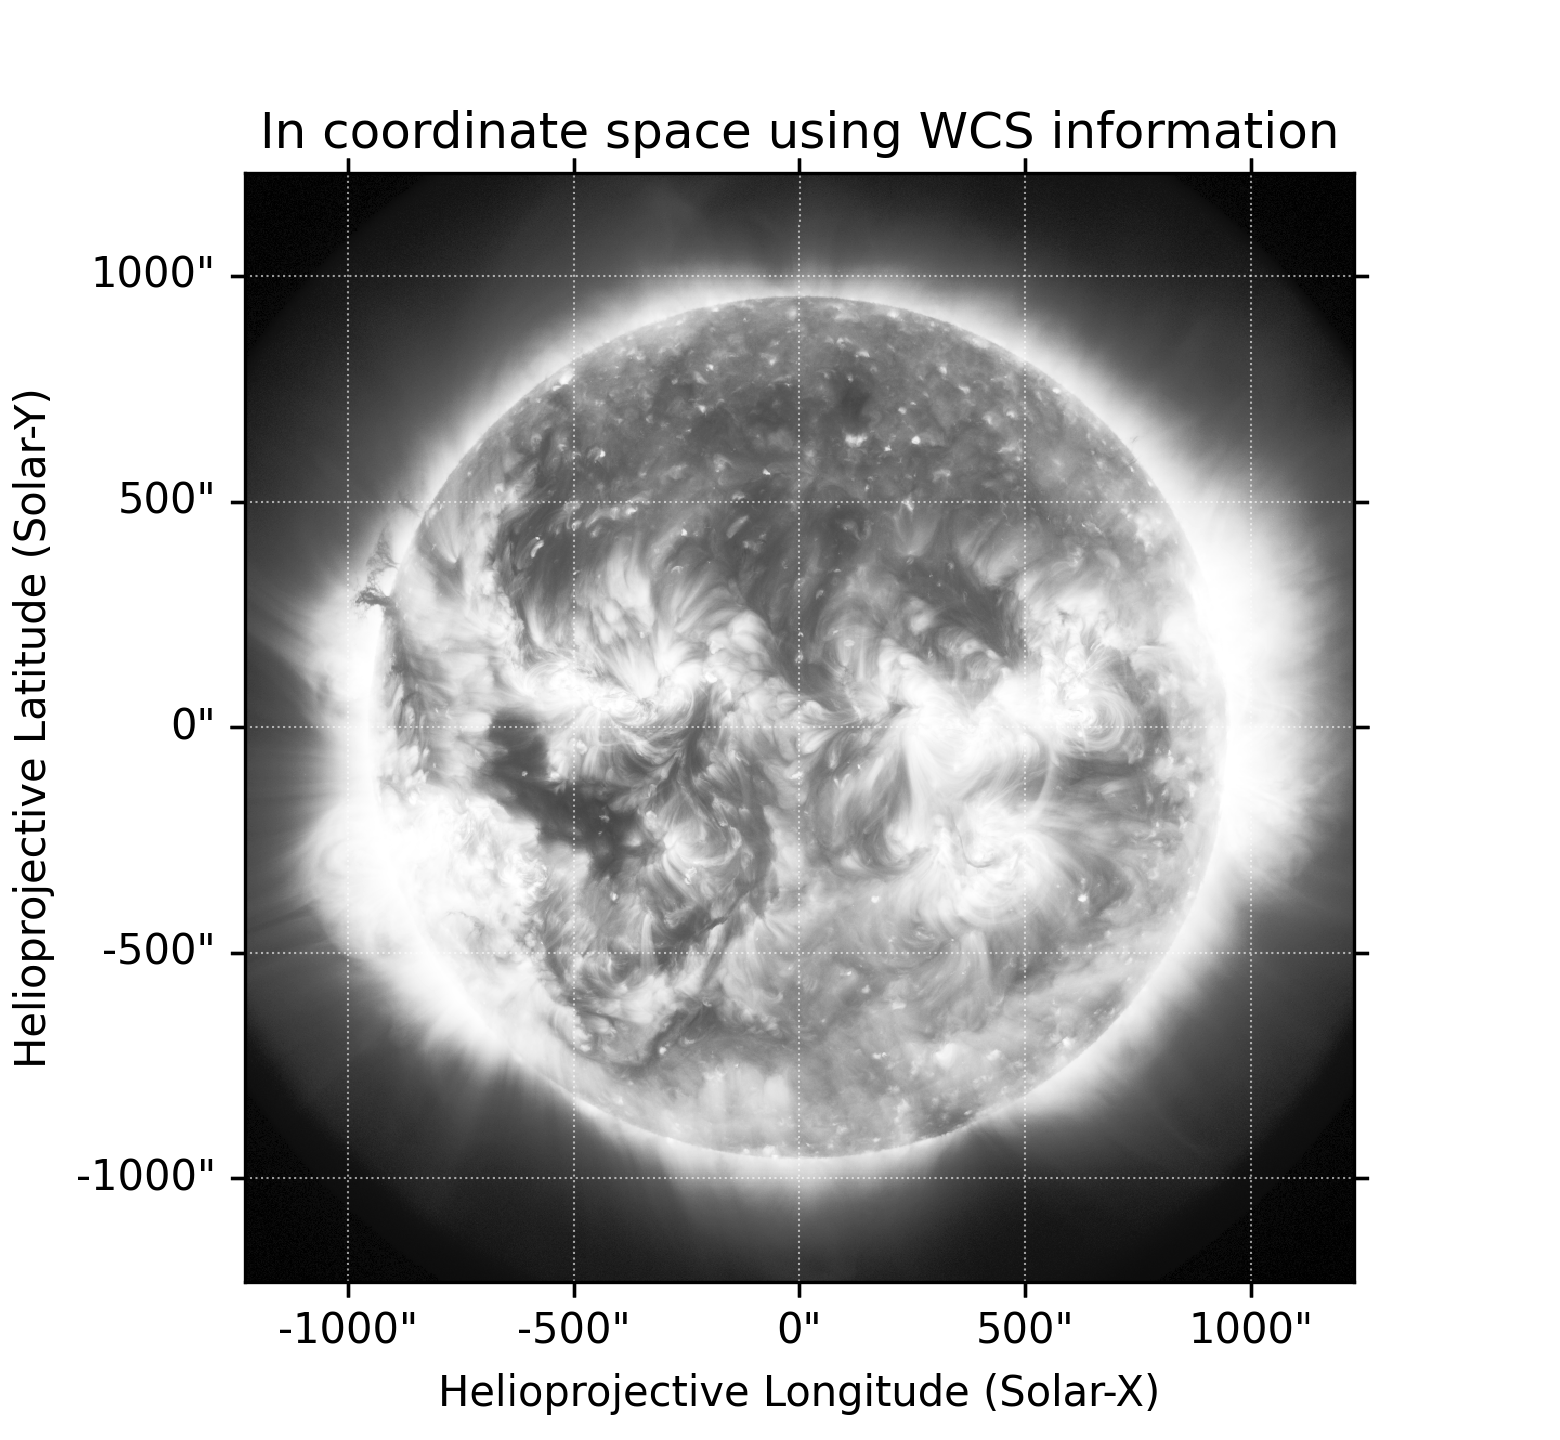
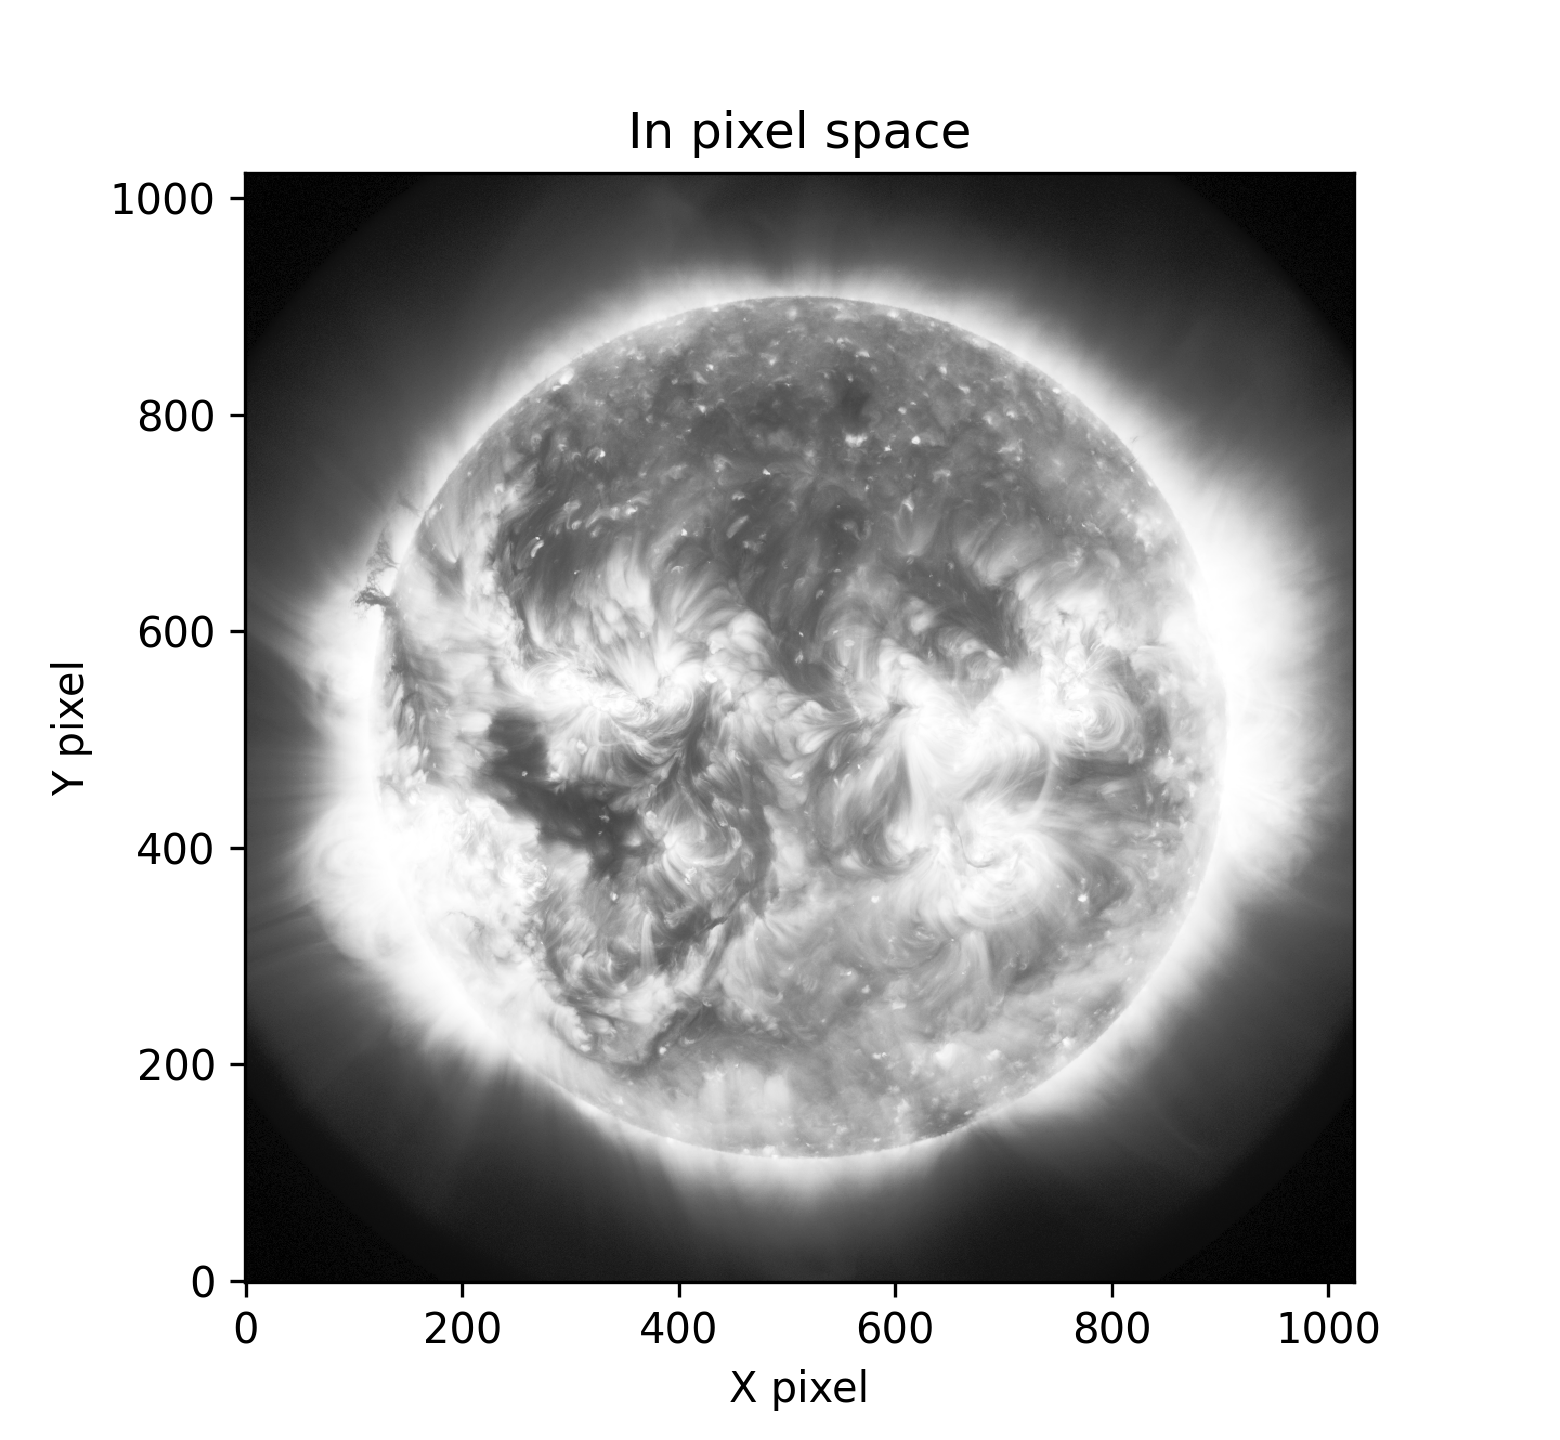
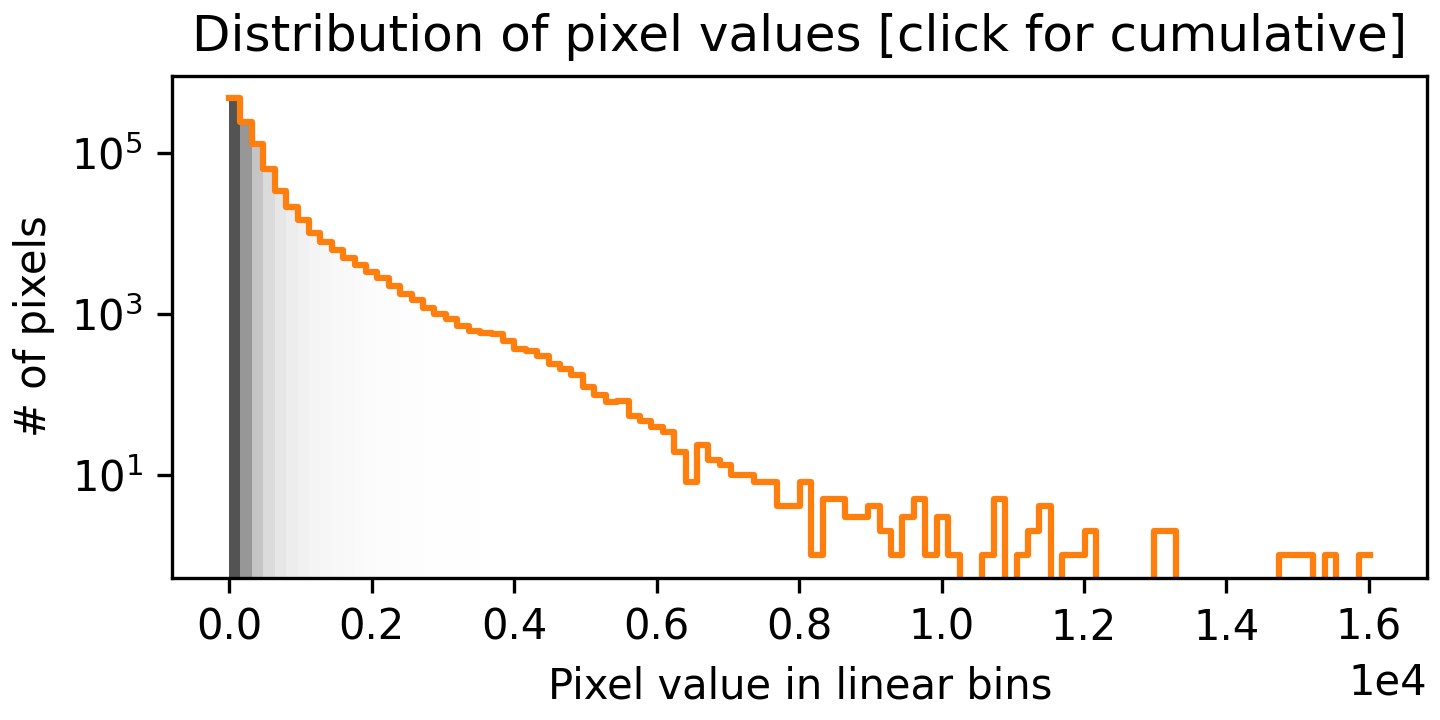
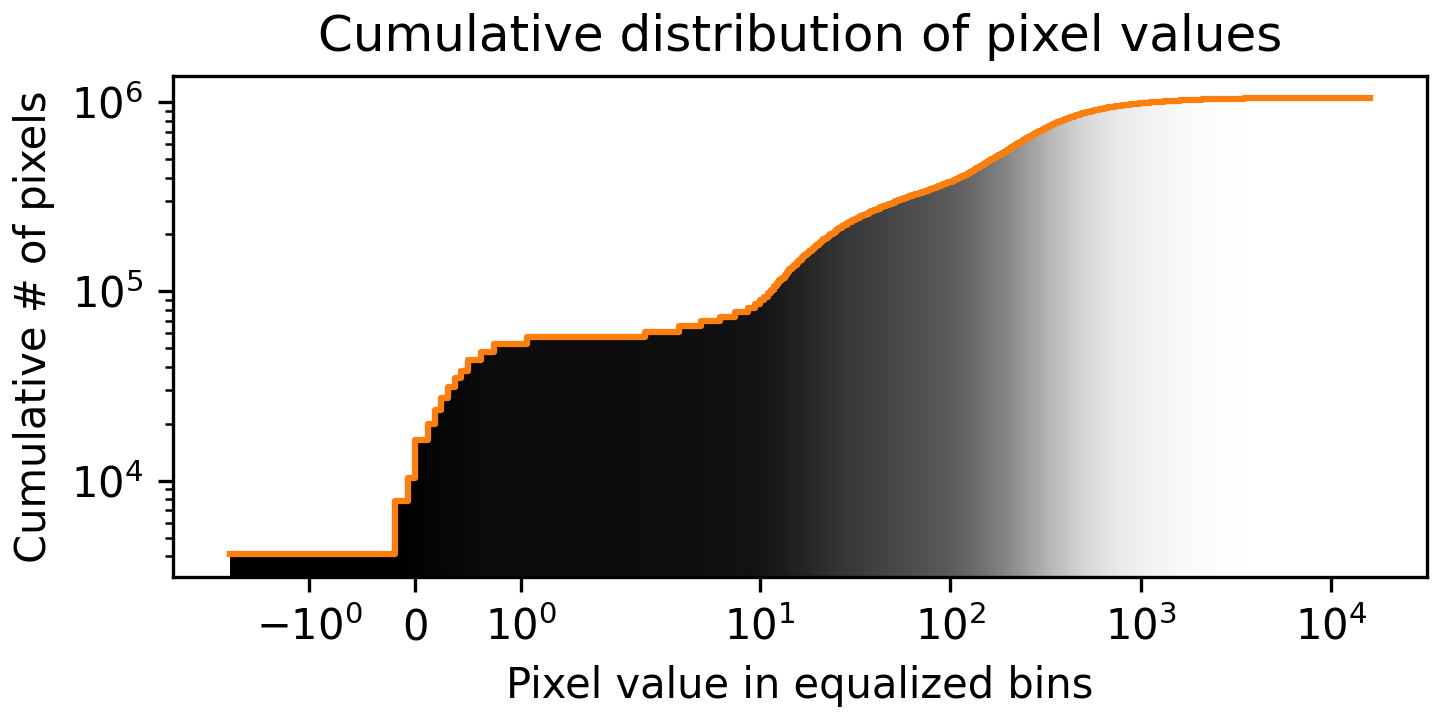

In [11]:
# show info about the SDO AIA map
aia

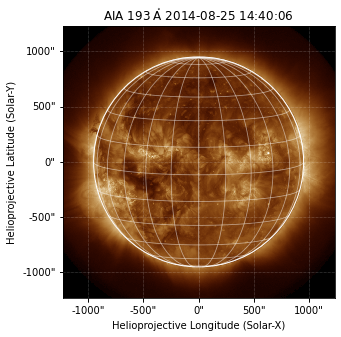

In [12]:
# show the AIA map and clip out the darkest 1% of pixels and the brightest 0.01% of pixels
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection=aia)
aia.plot(axes=ax)
aia.draw_limb()
aia.draw_grid()
plt.show()

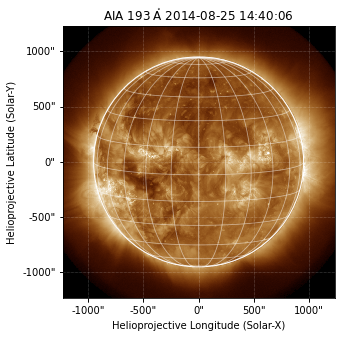

In [13]:
# show the AIA map and clip out the darkest 1% of pixels and the brightest 0.01% of pixels
plt.figure(figsize=(5,5))
aia.plot(clip_interval=(1, 99.99)*u.percent)
aia.draw_limb()
aia.draw_grid()
plt.show()

The [PFSS](https://pfsspy.readthedocs.io/en/stable/) solution is calculated on a regular 3D grid in (phi, s, rho), where
rho = ln(r), and r is the standard spherical radial coordinate. 

We need to define the number of grid points in rho, and the source surface radius. 

From the boundary condition, number of radial grid points, and source surface, we now construct an `Input` object that stores this information. 

Using the `Input` object, plot the input photospheric magnetic field. 

In [14]:
nrho = 50
rss = 3
pfss_in = pfsspy.Input(gong_map, nrho, rss)
pfss_out = pfsspy.pfss(pfss_in)

Now we construct a lat x lon grid of footpoitns to trace some magnetic field lines from. 

These coordinates are defined in the helioprojective frame of the AIA image 

In [15]:
num_footpoints = 20
lat = np.linspace(-0.4*np.pi, 0.5*np.pi, num_footpoints, endpoint=False)
lon = np.linspace(-0.5*np.pi, 1.5*np.pi, num_footpoints+10, endpoint=False)

lat, lon = np.meshgrid(lat, lon, indexing='ij')
lat, lon = lat.ravel()*u.rad, lon.ravel()*u.rad
r = 1.2*const.radius

# Make a 2D grid from these 1D points 
seeds = SkyCoord(lon, lat, r, frame=pfss_out.coordinate_frame)
tracer = tracing.FortranTracer()
flines = tracer.trace(seeds, pfss_out)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


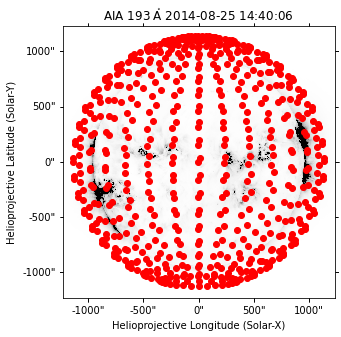

In [16]:
# Map of the footpoints
plt.figure(figsize=(5,5))
ax = plt.subplot(projection=aia)
(255-aia).plot(axes=ax, clip_interval=(1, 99.99)*u.percent, cmap='gray')
ax.plot_coord(seeds, color='red', marker='o', linewidth=0)
plt.show()

Plot the magnetogram and the seed footpoints. The footpoints are centered around the active region metnioned above 

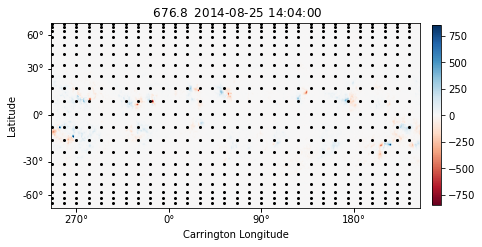

In [17]:
m = pfss_in.map
fig = plt.figure(figsize=(7,4))
ax = plt.subplot(projection=m)
gon = m.plot()
ax.plot_coord(seeds, color='black', marker='o', linewidth=0, markersize=2)
fig.colorbar(gon, fraction=0.023, pad=0.03)
plt.show()

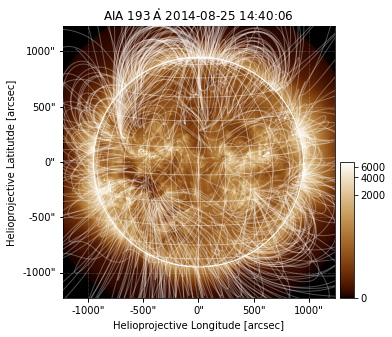

In [18]:
# SDO/AIA + PFSS
plt.figure(figsize=(5,5))
ax = plt.subplot(111, projection=aia)
# # clip out the darkest 1% of pixels and the brightest 0.01% of pixels 
im = aia.plot(axes=ax, clip_interval=(1, 99.99)*u.percent)
aia.draw_limb()
aia.draw_grid()

for fline in flines:
    ax.plot_coord(fline.coords, alpha=0.3, color='white', linewidth=1)

axins = inset_axes(ax, 
                   width='5%',    # width = 5% of parent_bbox width 
                   height='50%',  # height : 50% 
                   loc='lower left', bbox_to_anchor=(1.02,0,1,1), bbox_transform=ax.transAxes, borderpad=0.01)

fig.colorbar(im, cax=axins)
ax.set_xlabel('Helioprojective Longitude [arcsec]')
ax.set_ylabel('Helioprojective Latitutde [arcsec]')
ax.set_xlim(left=0, right=int(aia.dimensions.x.value))
ax.set_ylim(bottom=0, top=int(aia.dimensions.y.value))
plt.show()

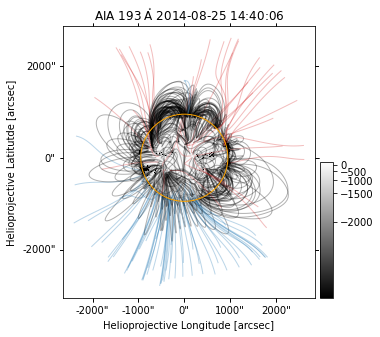

In [19]:
# SDO/AIA (negative map) + PFSS 
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111, projection=aia)
# clip out the darkest 1% of pixels and the brightest 0.01% of pixels 
im = (255-aia).plot(axes=ax, clip_interval=(1, 99.99)*u.percent, cmap='gray')
aia.draw_limb(color='orange')
#aia.draw_grid(color='orange')

for fline in flines:
    color = {0: 'black', -1: 'tab:blue', 1: 'tab:red'}.get(fline.polarity)
    ax.plot_coord(fline.coords, alpha=0.3, color=color, linewidth=1)

axins = inset_axes(ax, 
                   width='5%',    # width = 5% of parent_bbox width 
                   height='50%',  # height : 50% 
                   loc='lower left', bbox_to_anchor=(1.02,0,1,1), bbox_transform=ax.transAxes, borderpad=0.01)
fig.colorbar(im, cax=axins)
ax.set_xlabel('Helioprojective Longitude [arcsec]')
ax.set_ylabel('Helioprojective Latitutde [arcsec]')
plt.show()

Plot the SDO/AIA 193$\\A^o$ with the PFSS solution and the contour lines from LOFAR data 

`N.B. the contours in this plot aren't the correct ones for this datetime. I show them here just as an example. The code functionality works, just use the correct LOFAR data` 

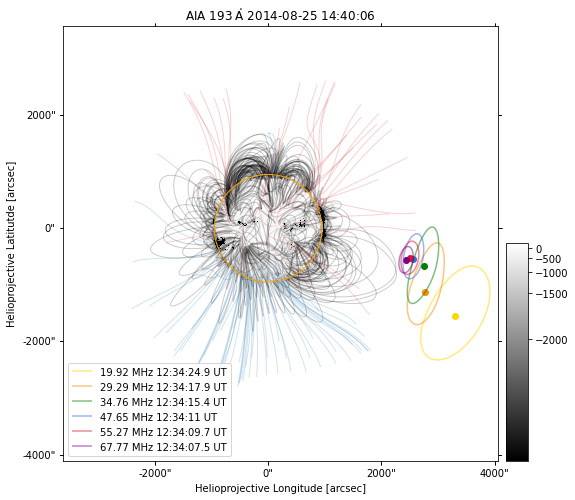

In [21]:
# SDO/AIA + PFSS + LOFAR 
hs, contours = [], []
freq_band, obs_date = [], []

# the following 5 lines are customized. You'll need to change them depending on your data and their filenames 
burst_num = 6
freqs = [19916, 29297, 34760, 47650, 55267, 67767] # in kHz 
subband = ['SB000', 'SB011', 'SB015', 'SB026', 'SB033', 'SB045']
st_idx = [18745, 18703, 18688, 18662, 18654, 18641]
cntr_color = ['gold','darkorange','green','royalblue','crimson','purple']


fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection=aia)
# clip out the darkest 1% of pixels and the brightest 0.01% of pixels 
im = (255-aia).plot(axes=ax, clip_interval=(1, 99.99)*u.percent, cmap='gray')
aia.draw_limb(color='orange')

for fline in flines:
    color = {0: 'black', -1: 'tab:blue', 1: 'tab:red'}.get(fline.polarity)
    ax.plot_coord(fline.coords, alpha=0.2, color=color, linewidth=1)

# calc the centroid loc with 2 meathods 
centroids_mean = np.zeros((len(freqs),2))
centroids_max = np.zeros((len(freqs),2))

for i in range(len(freqs)):
    lof_img = f'{basedir}/L700169_SAP000_{subband[i]}_burst{burst_num}_snapshot_{st_idx[i]}-image.fits'
    lofar_imagemap = get_lofar_map(lof_img, bottom_left=(-FOV,-FOV), top_right=(FOV,FOV))
    lofar_centLoc = np.unravel_index(np.nanargmax(lofar_imagemap.data), lofar_imagemap.data.shape)*u.pixel
    c_Arcsec = lofar_imagemap.pixel_to_world(lofar_centLoc[1], lofar_centLoc[0])
    
    with frames.Helioprojective.assume_spherical_screen(lofar_imagemap.observer_coordinate):
        c0 = lofar_imagemap.draw_contours(levels=(70)*u.percent, autoalign=True, linewidth=10, 
                                          alpha=0.5, colors=cntr_color[i])
        w = aia.wcs
        coord = w.world_to_pixel(c_Arcsec)
        ax.scatter(coord[0], coord[1], c=cntr_color[i])
        centroids_max[i] = np.array(coord)

    points0 = c0.allsegs[0][0]
    centroid0 = points0.mean(axis=0)
    centroids_mean[i] = np.array([centroid0[0], centroid0[1]])
    h0,_ = c0.legend_elements()
    hs.append(h0)
    contours.append(c0)

    # set the contours labels 
    freq_band.append(str(lofar_imagemap.wavelength))
    obs_date.append(str(datetime.strptime(lofar_imagemap.date.value, '%Y-%m-%dT%H:%M:%S.%f').time())[:10])
    
ax.legend([i[0] for i in hs], [f'{f} {t} UT' for f, t in zip(freq_band,obs_date)], loc='lower left')
axins = inset_axes(ax, 
                   width='5%',    # width = 5% of parent_bbox width 
                   height='50%',  # height : 50% 
                   loc='lower left', bbox_to_anchor=(1.02,0,1,1), bbox_transform=ax.transAxes, borderpad=0.01)

fig.colorbar(im, cax=axins)
ax.set_xlabel('Helioprojective Longitude [arcsec]')
ax.set_ylabel('Helioprojective Latitutde [arcsec]')
ax.set_xlim(left=-1000, right=2200)
ax.set_ylim(top=2000, bottom=-1200)
plt.show()